In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import random as rn
from sklearn.model_selection import KFold

In [2]:
# Variables globales
Imagenes = []
Etiquetas = []
IMG_TAM = 224  # Tamaño de las imágenes para MobileNet
DIR_BASE = 'D:/Documentos/Protocolo/app_escritorio/Aguacate completo'
DIR_MADURO = DIR_BASE+"/Maduro"
DIR_INMADURO = DIR_BASE+"/Inmaduro"

#Data augmentation
INMADURO_brillo = DIR_BASE + '/Inmaduro/DA/Brillo'
INMADURO_cs = DIR_BASE + '/Inmaduro/DA/Channel_Shift'
INMADURO_des = DIR_BASE + '/Inmaduro/DA/Desplazamiento'
INMADURO_flip = DIR_BASE + '/Inmaduro/DA/Flip_Horizontal'
INMADURO_rotacion = DIR_BASE + '/Inmaduro/DA/Rotacion'
INMADURO_zoom = DIR_BASE + '/Inmaduro/DA/Zoom'


MADURO_brillo = DIR_BASE + '/Maduro/DA/Brillo'
MADURO_cs = DIR_BASE + '/Maduro/DA/Channel_Shift'
MADURO_des = DIR_BASE + '/Maduro/DA/Desplazamiento'
MADURO_flip = DIR_BASE + '/Maduro/DA/Flip_Horizontal'
MADURO_rotacion = DIR_BASE + '/Maduro/DA/Rotacion'
MADURO_zoom = DIR_BASE + '/Maduro/DA/Zoom'



In [3]:
# Función para obtener extensiones de archivos
def obtener_extension_archivos(DIR):
    ext = []
    for archivo in os.listdir(DIR):
        nom_archivo, ext_archivo = os.path.splitext(archivo)
        ext.append(ext_archivo)
    extensiones = set(ext)
    print(extensiones)

# Función para validar imágenes
def imagen_valida(archivo, extensiones=[".jpg", ".png", ".JPG", ".PNG", ".jfif", ".jpeg"]):
    nom_archivo, ext_archivo = os.path.splitext(archivo)
    es_archivo = os.path.isfile(archivo)
    es_imagen = ext_archivo.lower() in extensiones
    return es_archivo and es_imagen

# Función para construir la base de datos
def construir_base_datos(etiqueta, DIR):
    for archivo in tqdm(os.listdir(DIR)):
        ruta = os.path.join(DIR, archivo)
        if imagen_valida(ruta):
            img = tf.keras.preprocessing.image.load_img(ruta, color_mode='rgb')
            matriz_img = tf.keras.preprocessing.image.img_to_array(img)
            matriz_img = tf.image.resize(matriz_img / 255, [IMG_TAM, IMG_TAM])  # Cambiar tamaño a 224x224
            Imagenes.append(matriz_img.numpy())
            Etiquetas.append(etiqueta)

In [4]:
# Obtener extensiones
obtener_extension_archivos(DIR_MADURO)
obtener_extension_archivos(DIR_INMADURO)

{'', '.png', '.JPG', '.jpg'}
{'', '.png', '.JPG', '.jpg'}


In [5]:
# Etiquetas de las clases
Imagenes = []
Etiquetas = []
clases = ['MADURO', 'INMADURO']
construir_base_datos(0, DIR_MADURO)
construir_base_datos(0, MADURO_brillo)
construir_base_datos(0, MADURO_rotacion)
construir_base_datos(0, MADURO_cs)
construir_base_datos(0, MADURO_des)
construir_base_datos(0, MADURO_flip)
construir_base_datos(0, MADURO_zoom)
construir_base_datos(1, DIR_INMADURO)
construir_base_datos(1, INMADURO_brillo)
construir_base_datos(1, INMADURO_rotacion)
construir_base_datos(1, INMADURO_cs)
construir_base_datos(1, INMADURO_des)
construir_base_datos(1, INMADURO_flip)
construir_base_datos(1, INMADURO_zoom)


# Codificar las etiquetas
codificadorEtiquetas = LabelEncoder()
claveEtiquetas = codificadorEtiquetas.fit_transform(Etiquetas)

# Convertir a one-hot
claveEtiquetas = tf.keras.utils.to_categorical(claveEtiquetas, num_classes=len(clases))

# Convertir las imágenes a un arreglo numpy
imagenes = np.array(Imagenes)
etiquetas = np.array(claveEtiquetas)

100%|██████████| 55/55 [00:05<00:00,  9.82it/s]


In [ ]:
#Sin aumento de imagenes
# Etiquetas de las clases
clases = ['MADURO', 'INMADURO']
construir_base_datos(0, DIR_MADURO)
construir_base_datos(1, DIR_INMADURO)


# Codificar las etiquetas
codificadorEtiquetas = LabelEncoder()
claveEtiquetas = codificadorEtiquetas.fit_transform(Etiquetas)

# Convertir a one-hot
claveEtiquetas = tf.keras.utils.to_categorical(claveEtiquetas, num_classes=len(clases))

# Convertir las imágenes a un arreglo numpy
imagenes = np.array(Imagenes)
etiquetas = np.array(claveEtiquetas)

 16%|█▌        | 30/191 [00:03<00:21,  7.52it/s]


KeyboardInterrupt: 

In [6]:
# Convertir las etiquetas a un arreglo numpy
etiq = np.array(Etiquetas)

# Contar la cantidad de imágenes por clase
cantidad_maduro= np.sum(etiq == 0)
cantidad_inmaduro = np.sum(etiq == 1)

# Imprimir las cantidades
print(f'Cantidad de imágenes en la clase "maduro": {cantidad_maduro}')
print(f'Cantidad de imágenes en la clase "inmaduro": {cantidad_inmaduro}')


Cantidad de imágenes en la clase "maduro": 350
Cantidad de imágenes en la clase "inmaduro": 385


In [7]:
# Definir el número de folds
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Guardar resultados de cada fold
fold_accuracies = []
fold_losses = []
fold_conf_matrices = []

for fold, (train_idx, test_idx) in enumerate(kf.split(imagenes)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Dividir los datos en conjuntos de entrenamiento y prueba para este fold
    img_entrenamiento, img_prueba = imagenes[train_idx], imagenes[test_idx]
    etq_entrenamiento, etq_prueba = etiquetas[train_idx], etiquetas[test_idx]

    # Crear el modelo MobileNet
    from tensorflow.keras.applications import VGG16

    modelo = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_TAM, IMG_TAM, 3))
    modelo.trainable = False  # Congelar las capas de VGG16

    # Agregar capas adicionales
    x = tf.keras.layers.Flatten()(modelo.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    salida = tf.keras.layers.Dense(len(clases), activation='softmax')(x) 

    modelo = tf.keras.Model(inputs=modelo.input, outputs=salida)

    # Compilar el modelo usando categorical_crossentropy
    modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    historial = modelo.fit(img_entrenamiento, etq_entrenamiento,
                           validation_data=(img_prueba, etq_prueba),
                           epochs=50, batch_size=32, verbose=1)

    # Evaluar el modelo en el conjunto de prueba
    resultados = modelo.evaluate(img_prueba, etq_prueba, verbose=0)
    print(f"Precisión en Fold {fold + 1}: {resultados[1] * 100:.2f}%")
    print(f"Loss en Fold {fold + 1}: {resultados[0]:.4f}")
    fold_accuracies.append(resultados[1])
    fold_losses.append(resultados[0])

    # Generar predicciones
    predicciones = modelo.predict(img_prueba)
    predicciones_etq = np.argmax(predicciones, axis=1)

    # Obtener las etiquetas verdaderas
    etq_verdaderas = np.argmax(etq_prueba, axis=1)

    # Generar matriz de confusión
    conf_matrix = confusion_matrix(etq_verdaderas, predicciones_etq)
    fold_conf_matrices.append(conf_matrix)

Fold 1/5
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.5150 - loss: 3.7566 - val_accuracy: 0.7211 - val_loss: 0.5279
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7877 - loss: 0.4481 - val_accuracy: 0.8503 - val_loss: 0.4159
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9011 - loss: 0.2843 - val_accuracy: 0.8844 - val_loss: 0.3085
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9497 - loss: 0.1806 - val_accuracy: 0.9048 - val_loss: 0.2570
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9591 - loss: 0.1557 - val_accuracy: 0.9184 - val_loss: 0.2079
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9726 - loss: 0.1054 - val_accuracy: 0.9184 - val_loss: 0.1896
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9683 - loss: 0.1194 - val_accuracy: 0.9252 - val_loss: 0.1813
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9777 - loss: 0.0821 - val_accuracy: 0.9320 - 

In [8]:
print(fold_accuracies)
print(fold_losses)

[0.9523809552192688, 0.9659863710403442, 0.9591836929321289, 0.9387755393981934, 0.9795918464660645]
[0.15379910171031952, 0.08621321618556976, 0.2522332966327667, 0.21346740424633026, 0.09110142290592194]


In [11]:
# Imprimir precisión promedio
prec_media = np.mean(fold_accuracies)
promedio_loss = np.mean(fold_losses)
#Desviacion Estandar
std_accuracy = np.std(fold_accuracies)
std_loss = np.std(fold_losses)

print(f"\nPromedio de Precisión en {k_folds} Folds: {prec_media * 100:.2f}%")
print(f"Desviación Estándar de Precisión en {k_folds} Folds: {std_accuracy:.4f}")
print(f"Promedio de Loss en {k_folds} Folds: {promedio_loss:.4f}")
print(f"Desviación Estándar de Loss en {k_folds} Folds: {std_loss:.4f}")


Promedio de Precisión en 5 Folds: 95.92%
Desviación Estándar de Precisión en 5 Folds: 0.0136
Promedio de Loss en 5 Folds: 0.1594
Desviación Estándar de Loss en 5 Folds: 0.0657


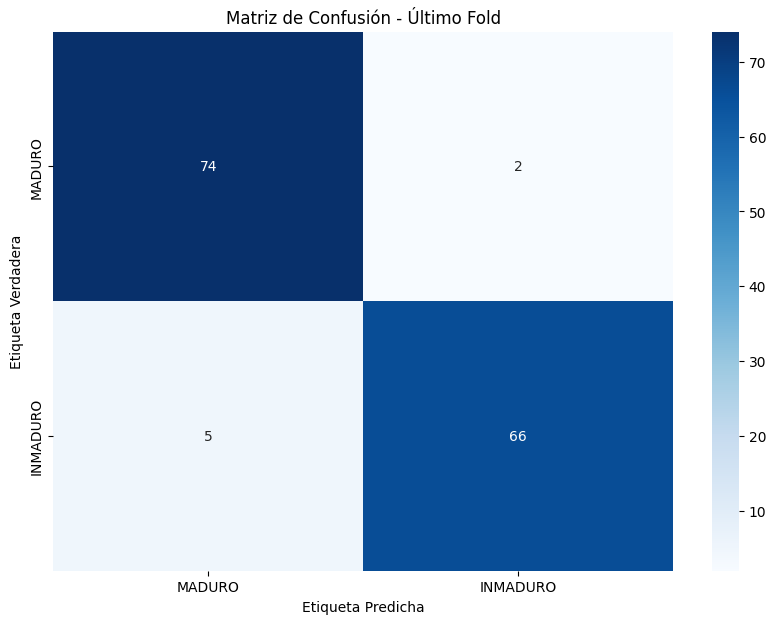

In [12]:
# Visualizar la matriz de confusión del último fold
plt.figure(figsize=(10, 7))
sns.heatmap(fold_conf_matrices[0], annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión - Último Fold')
plt.show()

In [37]:
modelo.save('modelo_entrenado_VGG16.keras')

In [3]:
print("GPU disponible:", tf.config.list_physical_devices('GPU'))


GPU disponible: []


In [18]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Ruta de la carpeta con las imágenes
carpeta_imagenes = "D:/Descargas/Nueva carpeta"

# Lista para guardar las imágenes procesadas
imagenes_procesadas = []

# Recorre la carpeta y carga las imágenes
for archivo in os.listdir(carpeta_imagenes):
    ruta_imagen = os.path.join(carpeta_imagenes, archivo)
    if archivo.endswith((".jpg", ".png", ".JPG", ".PNG", ".jfif", ".jpeg")):  # Verifica que sea un archivo de imagen
        # Carga la imagen con un tamaño adecuado para el modelo
        imagen = load_img(ruta_imagen, target_size=(224, 224))  # Ajusta el tamaño según tu modelo
        # Convierte la imagen en un array
        imagen_array = img_to_array(imagen)
        # Escala los valores de los píxeles entre 0 y 1
        imagen_array /= 255.0
        # Agrega una dimensión para el lote
        imagen_array = np.expand_dims(imagen_array, axis=0)
        # Guarda la imagen procesada
        imagenes_procesadas.append(imagen_array)

# Convierte la lista en un array numpy para la predicción
imagenes_procesadas = np.vstack(imagenes_procesadas)

# Generar predicciones
predicciones = modelo.predict(imagenes_procesadas)

# Convertir las predicciones a etiquetas (índices de clases)
predicciones_etq = np.argmax(predicciones, axis=1)

# Definir los nombres de las clases
nombres_clases = ['Maduro', 'Inmaduro']

# Asocia cada archivo con su etiqueta predicha
resultados = []
archivos = [archivo for archivo in os.listdir(carpeta_imagenes) if archivo.endswith((".jpg", ".png", ".JPG", ".PNG", ".jfif", ".jpeg"))]

for i, archivo in enumerate(archivos):
    etiqueta_predicha = nombres_clases[predicciones_etq[i]]
    resultados.append((archivo, etiqueta_predicha))

# Mostrar los resultados
for archivo, etiqueta in resultados:
    print(f"Archivo: {archivo} - Predicción: {etiqueta}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
Archivo: descarga.jpg - Predicción: Inmaduro
Archivo: images.jpg - Predicción: Maduro
Archivo: image_1024.jpg - Predicción: Inmaduro
Archivo: lf41.jpg - Predicción: Inmaduro
Archivo: maduracion-aguacate-1022x581.png - Predicción: Maduro
